In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os import path
import pickle

In [2]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 100

In [3]:
def put_content(files, directory):
    for file_name in files:
        ids.append(int(file_name.replace(".txt", "").split("_")[0]))
        grades.append(0 if int(file_name.replace(".txt", "").split("_")[1]) < 5 else 1)
        texts.append(open(path.join(directory, file_name), 'r').read())

In [4]:
# Подготовка тренировочного набора
ids = []
grades = []
texts = []

train_neg_dir = "aclImdb/train/neg"
train_pos_dir = "aclImdb/train/pos"

train_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_neg_dir)))
train_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_pos_dir)))

put_content(train_neg_files, train_neg_dir)
put_content(train_pos_files, train_pos_dir)

train_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

train_df = train_df.iloc[np.random.permutation(len(train_df))].reset_index(drop=True)

In [5]:
# Подготовка тестового набора
ids = []
grades = []
texts = []

test_neg_dir = "aclImdb/test/neg"
test_pos_dir = "aclImdb/test/pos"

test_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_neg_dir)))
test_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_pos_dir)))

put_content(test_neg_files, test_neg_dir)
put_content(test_pos_files, test_pos_dir)

test_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

test_df = test_df.iloc[np.random.permutation(len(test_df))].reset_index(drop=True)

In [6]:
# Создание токенайзера
tokenizer = Tokenizer(num_words=num_words)

In [7]:
# Тренировка токенайзера
tokenizer.fit_on_texts(train_df['text'])

In [8]:
# Сохранение токенайзера
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Преобразование текста в последовательности чисел
sequences = tokenizer.texts_to_sequences(train_df['text'])

In [10]:
# Ограничить длину отзыва
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [11]:
# Сверточная нейронная сеть

In [12]:
# Создание самой модели
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_news_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
# Компиляция модели
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 250)           40250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 250)           312750    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 250)           312750    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 84, 250)           312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [16]:
# Сохренение модели
model.save('model_binary')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_binary/assets


In [19]:
# Создаем callback для сохранения нейронной сети на каждой эпохе,
    # если качество работы на проверочном наборе данных улучшилось.
# Сеть сохраняется в файл best_model.h5
model_binary_save_path = 'best_model_binary.h5'
checkpoint_callback = ModelCheckpoint(model_binary_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [20]:
# Правильные ответы
y_train = train_df['grade']

In [22]:
history = model.fit(x_train, 
                            y_train, 
                            epochs=3,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback])

Epoch 1/3
176/176 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.6692
Epoch 00001: val_accuracy improved from -inf to 0.78960, saving model to best_model_binary.h5
176/176 [==============================] - 160s 909ms/step - loss: 0.5663 - accuracy: 0.6692 - val_loss: 0.4567 - val_accuracy: 0.7896
Epoch 2/3
176/176 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8561
Epoch 00002: val_accuracy improved from 0.78960 to 0.83240, saving model to best_model_binary.h5
176/176 [==============================] - 159s 901ms/step - loss: 0.3349 - accuracy: 0.8561 - val_loss: 0.3857 - val_accuracy: 0.8324
Epoch 3/3
176/176 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9081
Epoch 00003: val_accuracy improved from 0.83240 to 0.83400, saving model to best_model_binary.h5
176/176 [==============================] - 158s 896ms/step - loss: 0.2350 - accuracy: 0.9081 - val_loss: 0.3973 - val_accuracy: 0.8340


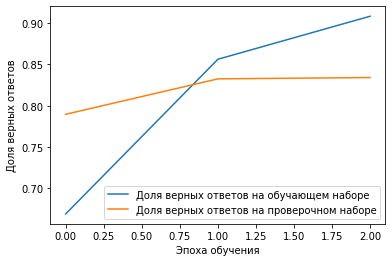

In [23]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [24]:
# Тестирование работы

In [25]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [26]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [27]:
# Правильные ответы на тестовом наборе
y_test = test_df['grade']

In [28]:
# Качество Одномерная сверточная сеть

In [30]:
from tensorflow import keras
model_binary = keras.models.load_model('model_binary')
model_binary_save_path = 'best_model_binary.h5'
model_binary.load_weights(model_binary_save_path)

In [31]:
# Определение доли верных ответов на тестовом наборе
model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 46s 58ms/step - loss: 0.3982 - accuracy: 0.8269


[0.3981826901435852, 0.8269199728965759]

In [32]:
# Оцениваем тональность на собственном отзыве

In [64]:
text = """
bad
"""

In [65]:
sequence = tokenizer.texts_to_sequences([text])

In [66]:
data = pad_sequences(sequence, maxlen=max_news_len)

In [67]:
result = round(10 * list(model_binary.predict(data)[0])[0])
if result < 1:
    result = 1
if result > 10:
    result = 10
list(model_binary.predict(data)[0])

[0.4122226]

In [68]:
result

4

In [69]:
print('Кол-во звезд отзыва', result)

Кол-во звезд отзыва 4


In [70]:
if list(model_binary.predict(data)[0])[0] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

Отзыв отрицательный
